# Football Passing Distributions  - Champions League 2012,2013,2015,2016

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import csv
import re
import os
from networkx.drawing.nx_agraph import graphviz_layout
from bs4 import BeautifulSoup
import urllib2
import pickle
from pyPdf import PdfFileWriter, PdfFileReader
from collections import defaultdict
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import NMF
from itertools import chain
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

In [ ]:
# with open('player.pickle', 'wb') as handle:
#     pickle.dump(playerdict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('player.pickle', 'rb') as handle:
    playerdict =  pickle.load(handle)

In [3]:
print playerdict['Lionel Messi']

{'closeness': 1.1070858166775097, 'height': 5.583333333333333, 'pagerank': 0.09973258861607952, 'Medium PC': 967, 'position': ['Forward'], 'Long PA': 138, 'Short PC': 618, 'Long PC': 100, 'Short PA': 779, 'betweeness': 0.0, 'Medium PA': 1157}


## Construct Rankings

In [4]:
season2012,season2013,season2015,season2016 = defaultdict(),defaultdict(),defaultdict(),defaultdict()
csvs = ['2012.csv','2013.csv','2015.csv','2016.csv']
for x in csvs :
    with open(x,'rb') as csvfile :
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader :
            if x == '2012.csv':
                try :
                    season2012[row[1]] = int(row[0])
                except ValueError :
                    pass
            elif x == '2013.csv':
                try :
                    season2013[row[1]] = int(row[0])
                except ValueError :
                    pass
            elif x == '2015.csv':
                try :
                    season2015[row[1]] = int(row[0])
                except ValueError :
                    pass
            else :
                try :
                    season2016[row[1]] = int(row[0])
                except ValueError:
                    pass

## Bulding Player Statistics

## Constructing the matrix - Baseline Model
###  Initial Feature Set to be used for link prediction
Player Height, Player Position, Receiver Position, Short Passes Accuracy, Medium Passes Accuracy, Long Passes Accuracy
Team Rank, Opposition Team Rank, Home or Away, Receiver Height, Time Player, Receiver Time Played

In [5]:
def playertype(a,b):
    if b in a:
        return 1
    else :
        return 0

In [60]:
files = os.listdir('CSVS')
teamdir = defaultdict()
playerpasses = {}
buildgraphs = {}
out =[]
count = 0
for x in files :
    count+=1
    filename = 'CSVS\\'+ x
    pdfname = re.sub("team[0-1].csv",".pdf",x)
    pdfpath = 'Data\\'+pdfname
    with open(pdfpath,'rb') as f:
        temp = PdfFileReader(f)
        team = temp.getDocumentInfo().title
    buildgraphs[x] = []
    #Team Creation
    if 'team0' in x and team!=None:
        my_team = team.split("_")[2]
        opp_team = team.split("_")[3]
        homeoraway = 1
    elif team!=None :
        my_team = team.split("_")[3]
        opp_team = team.split("_")[2]
        homeoraway = 0
    #Rank Selection
    if '2009' in x :
        if my_team in season2012 :
            my_rank = season2012[my_team]
        else :
            my_rank = 100
        if opp_team in season2012 :
            opp_rank = season2012[opp_team]
        else :
            opp_rank = 100
    elif '2011' in x :
        if my_team in season2013 :
            my_rank = season2013[my_team]
        else :
            my_rank = 100
        if opp_team in season2013 :
            opp_rank = season2013[opp_team]
        else :
            opp_rank = 100
    elif '2015' in x :
        if my_team in season2015 :
            my_rank = season2015[my_team]
        else :
            my_rank = 100
        if opp_team in season2015 :
            opp_rank = season2015[opp_team]
        else :
            opp_rank = 100
    elif '2019' in x :
        if my_team in season2016 :
            my_rank = season2016[my_team]
        else :
            my_rank = 100
        if opp_team in season2016 :
            opp_rank = season2016[opp_team]
        else :
            opp_rank = 100
    
    ptcount = 0
    tplayers = []
    
    #Using 1 hot encoding
    isdefender, isinfielder, isforward,ismidfielder,isgoalkeeper,iswinger =[],[],[],[],[],[]
    timeplayed = []
    passheight = []
    with open(filename,'rb') as csvfile :
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader :
            if row[0] != 'Total passes received:':
                name = re.sub("[0-9]", " ", row[0]).strip().decode('utf-8',"ignore")
                tplayers.append(name)
                isdefender.append(playertype(playerdict[name]['position'],'Defender'))
                isforward.append(playertype(playerdict[name]['position'],'Forward'))
                ismidfielder.append(playertype(playerdict[name]['position'],'Midfielder'))
                isgoalkeeper.append(playertype(playerdict[name]['position'],'Goalkeeper'))
                isinfielder.append(playertype(playerdict[name]['position'],'Infielder'))
                iswinger.append(playertype(playerdict[name]['position'],'Winger'))
                passheight.append(playerdict[name]['height'])
                try :
                    timeplayed.append(int(re.split(r"\'",row[1])[0]))
                except ValueError:
                    timeplayed.append(1)
                    
    print x,count,len(out)
    
    with open(filename,'rb') as csvfile :
        reader = csv.reader(csvfile, delimiter=',')
        partial_out = []
        for row in reader :
            if row[0] != 'Total passes received:' and row[0]!=None:
                playerlist = [tplayers[ptcount]]*len(tplayers)
                try :
                    mytimeplayed = [int(re.split(r"\'",row[1])[0])]*len(tplayers)
                except ValueError:
                    mytimeplayed = [0]*len(tplayers)
                my_teamlist = [my_team]*len(tplayers)
                oppteamlist = [opp_team]*len(tplayers)
                mydefender = [playertype(playerdict[tplayers[ptcount]]['position'],'Defender')]*len(tplayers)
                mymidfielder = [playertype(playerdict[tplayers[ptcount]]['position'],'Midfielder')]*len(tplayers)
                mywinger = [playertype(playerdict[tplayers[ptcount]]['position'],'Winger')]*len(tplayers)
                myforward = [playertype(playerdict[tplayers[ptcount]]['position'],'Forward')]*len(tplayers)
                myinfielder = [playertype(playerdict[tplayers[ptcount]]['position'],'Infielder')]*len(tplayers)
                mygoalkeeper = [playertype(playerdict[tplayers[ptcount]]['position'],'Goalkeeper')]*len(tplayers)
                my_ranklist = [my_rank]*len(tplayers)
                opp_ranklist = [opp_rank]*len(tplayers)
                height_list = [playerdict[tplayers[ptcount]]['height']]*len(tplayers)
                prlist = [playerdict[tplayers[ptcount]]['pagerank']]*len(tplayers)
                cllist = [playerdict[tplayers[ptcount]]['closeness']]*len(tplayers)
                btlist = [playerdict[tplayers[ptcount]]['betweeness']]*len(tplayers)
                homeoraway_list = [homeoraway]*len(tplayers)
                shortpa_accuracy = float(float(playerdict[tplayers[ptcount]]['Short PC'])/float(playerdict[tplayers[ptcount]]['Short PA']))
                mediumpa_accuracy = float(float(playerdict[tplayers[ptcount]]['Medium PC'])/float(playerdict[tplayers[ptcount]]['Medium PA']))
                longpa_accuracy = float(float(playerdict[tplayers[ptcount]]['Long PC'])/float(playerdict[tplayers[ptcount]]['Long PA']))
                percentlong = float(playerdict[tplayers[ptcount]]['Long PC'])/(float(playerdict[tplayers[ptcount]]['Long PC']) + float(playerdict[tplayers[ptcount]]['Medium PC']) + float(playerdict[tplayers[ptcount]]['Short PC']))
                percentmedium = float(playerdict[tplayers[ptcount]]['Medium PC'])/(float(playerdict[tplayers[ptcount]]['Long PC']) + float(playerdict[tplayers[ptcount]]['Medium PC']) + float(playerdict[tplayers[ptcount]]['Short PC']))
                percentshort = float(playerdict[tplayers[ptcount]]['Short PC'])/(float(playerdict[tplayers[ptcount]]['Long PC']) + float(playerdict[tplayers[ptcount]]['Medium PC']) + float(playerdict[tplayers[ptcount]]['Short PC']))
                shortpa_list = [shortpa_accuracy]*len(tplayers)
                mediumpa_list = [mediumpa_accuracy]*len(tplayers)
                longpa_list = [longpa_accuracy]*len(tplayers)
                plonglist = [percentlong]*len(tplayers)
                pmediumlist = [percentmedium]*len(tplayers)
                pshortlist = [percentshort]*len(tplayers)
#                 playerfeatures = list(playerdata[tplayers[ptcount]]['totals'][0])
#                 myteamfeatures = list(teamdata[my_team]['features'][0])
#                 oppteamfeatures = list(teamdata[opp_team]['features'][0])
                for q in range(len(row)) :
                    if row[q] == '-' or row[q] == '' :
                        row[q] = 0
                if tplayers[ptcount] in playerpasses :
                    summer = row[3:len(tplayers)+3]
                    summer = [int(g) for g in summer]
                    playerpasses[tplayers[ptcount]].append((sum(summer),mytimeplayed[0],x.split('_')[0]))
                else :
                    summer = row[3:len(tplayers)+3]
                    summer = [int(g) for g in summer]
                    playerpasses[tplayers[ptcount]] = [(sum(summer),mytimeplayed[0],x.split('_')[0])]
                buildgraphs[x].extend(zip(playerlist,tplayers,row[3:len(tplayers)+3],my_ranklist,opp_ranklist,mytimeplayed,my_teamlist,oppteamlist,homeoraway_list))
                temp_out = zip(shortpa_list,mediumpa_list,longpa_list,plonglist,pshortlist,pmediumlist,mydefender,mymidfielder,mywinger,myforward,myinfielder,mygoalkeeper,my_ranklist,mytimeplayed,timeplayed,opp_ranklist,height_list,passheight,homeoraway_list,isdefender,isinfielder,ismidfielder,isgoalkeeper,iswinger,isforward,prlist,cllist,btlist,row[3:len(tplayers)+3])
#                 temp1_out = []
#                 for x in temp_out :
#                     x = list(x)
#                     x[-2:-2] = playerdict[tplayers[ptcount]]['features']
#                     #x[-2:-2] = myteamfeatures
#                     #x[-2:-2] = oppteamfeatures
#                     temp1_out.append(x)
            ptcount+=1
            partial_out += temp_out
    out += partial_out
        

C:\Users\abhna\Anaconda2\lib\site-packages\ipykernel\__main__.py:31: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
C:\Users\abhna\Anaconda2\lib\site-packages\ipykernel\__main__.py:27: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


2009488_tpdteam0.csv 1 0
2009488_tpdteam1.csv 2 210
2009489_tpdteam0.csv 3 420
2009489_tpdteam1.csv 4 602
2009490_tpdteam0.csv 5 812
2009490_tpdteam1.csv 6 1022
2009491_tpdteam0.csv 7 1232
2009491_tpdteam1.csv 8 1442
2009492_tpdteam0.csv 9 1652
2009492_tpdteam1.csv 10 1862
2009493_tpdteam0.csv 11 2072
2009493_tpdteam1.csv 12 2254
2009494_tpdteam0.csv 13 2464
2009494_tpdteam1.csv 14 2674
2009496_tpdteam0.csv 15 2884
2009496_tpdteam1.csv 16 3094
2009497_tpdteam0.csv 17 3304
2009497_tpdteam1.csv 18 3514
2009498_tpdteam0.csv 19 3724
2009498_tpdteam1.csv 20 3934
2009499_tpdteam0.csv 21 4144
2009499_tpdteam1.csv 22 4354
2009500_tpdteam0.csv 23 4564
2009500_tpdteam1.csv 24 4774
2009501_tpdteam0.csv 25 4984
2009501_tpdteam1.csv 26 5194
2009502_tpdteam0.csv 27 5404
2009502_tpdteam1.csv 28 5614
2009503_tpdteam0.csv 29 5796
2009503_tpdteam1.csv 30 6006
2009504_tpdteam0.csv 31 6216
2009504_tpdteam1.csv 32 6426
2009505_tpdteam0.csv 33 6636
2009505_tpdteam1.csv 34 6846
2009506_tpdteam0.csv 35 7042
2

2011782_tpdteam1.csv 294 60073
2011783_tpdteam0.csv 295 60283
2011783_tpdteam1.csv 296 60493
2011784_tpdteam0.csv 297 60703
2011784_tpdteam1.csv 298 60913
2011785_tpdteam0.csv 299 61123
2011785_tpdteam1.csv 300 61333
2011786_tpdteam0.csv 301 61543
2011786_tpdteam1.csv 302 61725
2011787_tpdteam0.csv 303 61935
2011787_tpdteam1.csv 304 62145
2011788_tpdteam0.csv 305 62355
2011788_tpdteam1.csv 306 62565
2011789_tpdteam0.csv 307 62775
2011789_tpdteam1.csv 308 62985
2011790_tpdteam0.csv 309 63167
2011790_tpdteam1.csv 310 63377
2011791_tpdteam0.csv 311 63587
2011791_tpdteam1.csv 312 63797
2011792_tpdteam0.csv 313 64007
2011792_tpdteam1.csv 314 64189
2011793_tpdteam0.csv 315 64399
2011793_tpdteam1.csv 316 64609
2011794_tpdteam0.csv 317 64819
2011794_tpdteam1.csv 318 65029
2011795_tpdteam0.csv 319 65239
2011795_tpdteam1.csv 320 65449
2011796_tpdteam0.csv 321 65659
2011796_tpdteam1.csv 322 65869
2011797_tpdteam0.csv 323 66079
2011797_tpdteam1.csv 324 66261
2011798_tpdteam0.csv 325 66471
2011798_

2015696_tpdteam0.csv 559 114553
2015696_tpdteam1.csv 560 114763
2015697_tpdteam0.csv 561 114973
2015697_tpdteam1.csv 562 115183
2015698_tpdteam0.csv 563 115393
2015698_tpdteam1.csv 564 115603
2015699_tpdteam0.csv 565 115813
2015699_tpdteam1.csv 566 116023
2015700_tpdteam0.csv 567 116205
2015700_tpdteam1.csv 568 116415
2015701_tpdteam0.csv 569 116625
2015701_tpdteam1.csv 570 116835
2015702_tpdteam0.csv 571 117045
2015702_tpdteam1.csv 572 117227
2015703_tpdteam0.csv 573 117383
2015703_tpdteam1.csv 574 117593
2015704_tpdteam0.csv 575 117803
2015704_tpdteam1.csv 576 118013
2015705_tpdteam0.csv 577 118169
2015705_tpdteam1.csv 578 118351
2015706_tpdteam0.csv 579 118533
2015706_tpdteam1.csv 580 118743
2015707_tpdteam0.csv 581 118925
2015707_tpdteam1.csv 582 119135
2015708_tpdteam0.csv 583 119345
2015708_tpdteam1.csv 584 119555
2015709_tpdteam0.csv 585 119765
2015709_tpdteam1.csv 586 119975
2015710_tpdteam0.csv 587 120185
2015710_tpdteam1.csv 588 120395
2015711_tpdteam0.csv 589 120605
2015711_

2019332_tpdteam0.csv 847 173245
2019332_tpdteam1.csv 848 173427
2019333_tpdteam0.csv 849 173637
2019333_tpdteam1.csv 850 173847
2019334_tpdteam0.csv 851 174057
2019334_tpdteam1.csv 852 174267
2019335_tpdteam0.csv 853 174477
2019335_tpdteam1.csv 854 174687
2019336_tpdteam0.csv 855 174869
2019336_tpdteam1.csv 856 175051
2019337_tpdteam0.csv 857 175261
2019337_tpdteam1.csv 858 175471
2019338_tpdteam0.csv 859 175681
2019338_tpdteam1.csv 860 175891
2019339_tpdteam0.csv 861 176101
2019339_tpdteam1.csv 862 176311
2019340_tpdteam0.csv 863 176521
2019340_tpdteam1.csv 864 176731
2019341_tpdteam0.csv 865 176941
2019341_tpdteam1.csv 866 177151
2019342_tpdteam0.csv 867 177361
2019342_tpdteam1.csv 868 177543
2019343_tpdteam0.csv 869 177699
2019343_tpdteam1.csv 870 177909
2019344_tpdteam0.csv 871 178119
2019344_tpdteam1.csv 872 178329
2019345_tpdteam0.csv 873 178539
2019345_tpdteam1.csv 874 178749
2019346_tpdteam0.csv 875 178931
2019346_tpdteam1.csv 876 179113
2019347_tpdteam0.csv 877 179323
2019347_

In [ ]:
# with open('matrixdata', 'wb') as handle:
#     pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)
# # with open('buildgraphs', 'wb') as handle:
# #     pickle.dump(buildgraphs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('matrixdata', 'rb') as handle:
    out = pickle.load(handle)
with open('buildgraphs', 'rb') as handle:
    buildgraphs = pickle.load(handle)

In [33]:
shuffle(out)
print len(out)

201591


In [38]:
from sklearn.preprocessing import scale
trial = scale(np.matrix(out[:160000]))
test = scale(np.matrix(out[160000:]))

C:\Users\abhna\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype |S32 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [39]:
trial.shape

(160000L, 29L)

In [40]:
print trial[0][0]

0.261693785082


In [41]:
x,y = np.split(trial,[28],axis=1)
x = x.astype('float')
y = y.astype('float')
print x[0]
print y[0]

[ 0.26169379 -0.21832803  2.2521071  -0.16602842  1.13663322 -1.18914707
 -0.66572041 -0.90161406 -0.02236627  1.72621045 -0.00829185 -0.25419581
 -0.10068426 -1.99084013 -0.03233854  0.62401477 -0.14811813 -0.15294514
  1.05776582 -0.68145686 -0.00968291 -0.88246598 -0.26404343 -0.02015974
  1.76599042  0.37659146  0.40243672  0.        ]
[-0.6343217]


In [ ]:
with open('matrixX', 'wb') as handle:
    pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('matrixY', 'wb') as handle:
    pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
theta,residuals,rank,s = np.linalg.lstsq(x, y)

In [43]:
print theta.transpose()
#Features - mydefender,mymidfielder,mywinger,myforward,myinfielder,mygoalkeeper,my_ranklist,mytimeplayed,timeplayed,opp_ranklist,height_list,passheight,homeoraway_list,shortpa_list,mediumpa_list,longpa_list,isdefender,isinfielder,ismidfielder,isgoalkeeper,iswinger,isforward

[[  5.19138884e-02   3.84920891e-02   4.43907196e-02   5.40955814e+08
    6.45091428e+08   5.41075467e+08  -1.92402545e-03   2.41278441e-02
   -1.57613133e-03  -4.76637483e-02   2.06181034e-03  -8.32005590e-02
   -5.04124761e-02   2.77736306e-01   2.58671924e-01   4.23973575e-02
    1.62568763e-02   1.12639889e-02   8.11190903e-03  -2.24369727e-02
    5.22301719e-03   4.79124635e-02  -1.40911827e-01  -1.49475783e-03
   -4.86577917e-02   2.00700998e-01  -7.39058256e-02   0.00000000e+00]]


In [44]:
print residuals

[]


In [45]:
testx,testy = np.split(test,[28],axis=1)
testx = testx.astype('float')
testy = testy.astype('float')
predicttesty = np.matmul(testx,theta)
mean_squared_error(testy,predicttesty)
zero = np.zeros((41591,1))
mean_squared_error(testy,zero)
total = float(sum(y)*1.0/len(y))
total = [total]*len(predicttesty)
print mean_squared_error(total,testy)
print mean_squared_error(zero,testy)
print r2_score(testy,predicttesty)
print r2_score(testy,total)
print r2_score(testy,zero)

1.0
1.0
-5.71875539401e+12
0.0
0.0


In [46]:
gbr = GradientBoostingRegressor()
gbr.fit(x,y)
gbrpredict = gbr.predict(testx)
for a in gbrpredict:
    if a<0 :
        a=0
print gbr.score(testx,gbrpredict)

C:\Users\abhna\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0


In [48]:
print r2_score(testy,gbrpredict)
print mean_squared_error(testy,gbrpredict)

0.301793327795
0.698206672205


In [50]:
print gbr.feature_importances_

[ 0.0266604   0.04636808  0.02276374  0.00719352  0.04063146  0.0400617
  0.02259123  0.00819679  0.          0.00639933  0.          0.
  0.06371062  0.15031317  0.14512499  0.05311307  0.01092286  0.02482758
  0.          0.02664662  0.          0.02156571  0.05362538  0.
  0.03377156  0.12651368  0.0689985   0.        ]


In [ ]:
rf = RandomForestRegressor()
rf.fit(x,y)
rfpredict = rf.predict(testx)
for a in rfpredict :
    if a<0 :
        a=0
print rf.score(testx,rfpredict)
print r2_score(testy,rfpredict)
print mean_squared_error(testy,rfpredict)

In [ ]:
baselinex,throw = np.split(x,[6],axis=1)
baselinetestx,throw = np.split(testx,[6],axis=1)
gbrbase = GradientBoostingRegressor()
gbrbase.fit(baselinex,y)
gbrbasepredict = gbrbase.predict(baselinetestx)
for a in gbrbasepredict:
    if a<0 :
        a=0
print gbrbase.score(baselinetestx,gbrbasepredict)
print r2_score(testy,gbrbasepredict)
print mean_squared_error(testy,gbrbasepredict)

In [ ]:
np.var(y)

In [26]:
# Build Graphs and get Centralities
playergraphdata = {}
playerdata = {}
playerfeat = {}
teamdata = {}
count = 0
edgedict = {}
teameigen = {}
for x in playerdict:
    playergraphdata[x] = []
    playerdata[x] = {}
    playerdata[x]['totals'] = np.zeros((1,4))
    playerdata[x]['length'] = 0
    playerfeat[x] = {}
for x in buildgraphs:
    G = nx.DiGraph()
    timepl = {}
    mrank = {}
    orank = {}
    for a in buildgraphs[x] :
#         if G.has_edge(a[0],a[1]):
#             G[a[0]][a[1]]['weight']+=int(a[2])
#             edgedict[(a[0],a[1])] +=1
#         else :
        G.add_edge(a[0],a[1],weight=int(a[2]))
#             edgedict[(a[0],a[1])] =1
        count+=int(a[2])
        timepl[a[0]] = int(a[5])
        mrank[a[0]] = int(a[3])
        orank[a[0]] = int(a[4])
        my_team = a[6]
        opp_team = a[7]
        ha = a[8]
    pgc = nx.pagerank(G)
    closec = nx.closeness_centrality(G)
    betweenc = nx.betweenness_centrality(G)
    players = G.nodes()
    adj = nx.to_numpy_matrix(G)
    model = NMF(n_components=4)
    W = model.fit_transform(adj)
    if ha == 1 :
        my_team = my_team + " Home"
    else :
        my_team = my_team + " Away"
    if my_team in teameigen :
        teameigen[my_team][x.split('_')[0]] = sorted(list(np.linalg.eigvals(adj)),reverse=True)
    else :
        teameigen[my_team] = {}
        teameigen[my_team][x.split('_')[0]] = sorted(list(np.linalg.eigvals(adj)),reverse=True)
#     teamf.fit(adj)
#     features = list(teamf.components_[0])[:14]
#     print len(features)
#     if len(features)<14 :
#         while len(features)<14:
#             features.extend([0])
#         print "After Correction", len(features)
    for m in range(len(players)) :
        playergraphdata[players[m]].append((pgc[players[m]],closec[players[m]],betweenc[players[m]],timepl[players[m]],mrank[players[m]],orank[players[m]],int(x.split('_')[0])))
        playerfeat[players[m]][x.split('_')[0]] = list(W[:][m])
        
#         playerdata[players[m]]['totals'] = np.add(playerdata[players[m]]['totals'],W[m])
#         playerdata[players[m]]['length']+=1
#     if my_team in teamdata :
#         teamdata[my_team]['features'] = np.add(teamdata[my_team]['features'],features)
#         teamdata[my_team]['length'] +=1
#     else :
#         teamdata[my_team] = {}
#         teamdata[my_team]['features'] = np.add(np.zeros((1,14)),features)
#         teamdata[my_team]['length'] =1        

In [ ]:
for x in teamdata:
    teamdata[x]['features'] = teamdata[x]['features']/teamdata[x]['length']
    teamdata[x]['length'] = 1
for x in playerdata :
    playerdata[x]['totals'] = playerdata[x]['totals']/playerdata[x]['length']
    playerdata[x]['length'] = 1

## Refined Player Data

In [31]:
for x in playergraphdata :
    b,c,p = 0,0,0
    for a in playergraphdata[x]:
        try :
            p+= a[0]*1.0*92.0/a[3]
            c+= a[1]*1.0*92.0/a[3]
            b+= a[2]*1.0*92.0/a[3]
        except ZeroDivisionError :
            p+= a[0]*1.0*92.0/1.0
            c+= a[1]*1.0*92.0/1.0
            b+= a[2]*1.0*92.0/1.0
    p = p*1.0/len(playergraphdata[x])
    c = c*1.0/len(playergraphdata[x])
    b = b*1.0/len(playergraphdata[x])
    playerdict[x]['pagerank'] = p
    playerdict[x]['closeness'] = c
    playerdict[x]['betweeness'] = b

In [32]:
print sorted(playergraphdata['Lionel Messi'],key = lambda x :x[-1])
# print playerdict['Lionel Messi']

[(0.08505538908161939, 1.0, 0.0, 95, 1, 58, 2009492), (0.07614321940360068, 1.0, 0.0, 96, 1, 9, 2009516), (0.0937788155466496, 1.0, 0.0, 96, 1, 62, 2009533), (0.1027740354060679, 1.0, 0.0, 94, 1, 62, 2009541), (0.07902662208866665, 1.0, 0.0, 94, 1, 58, 2009564), (0.030514411291768705, 1.0, 0.0, 37, 1, 9, 2009572), (0.08191913208878229, 1.0, 0.0, 95, 27, 4, 2009590), (0.10670174686653369, 1.0, 0.0, 94, 27, 4, 2009596), (0.06703038208259171, 1.0, 0.0, 46, 27, 4, 2009602), (0.037439627641363334, 1.0, 0.0, 32, 27, 4, 2009604), (0.09624530843944411, 1.0, 0.0, 93, 27, 4, 2009609), (0.07771574643458783, 1.0, 0.0, 94, 2, 30, 2011766), (0.11598206994205469, 1.0, 0.0, 93, 2, 11, 2011806), (0.11059975294194807, 1.0, 0.0, 92, 2, 11, 2011814), (0.10303486048196261, 1.0, 0.0, 93, 2, 22, 2011855), (0.08466698434990308, 1.0, 0.0, 93, 2, 22, 2011865), (0.09295229216947203, 1.0, 0.0, 96, 2, 7, 2011871), (0.08003076586947525, 1.0, 0.0, 94, 2, 7, 2011877), (0.1401410947190021, 1.0, 0.0, 96, 3, 51, 2015674

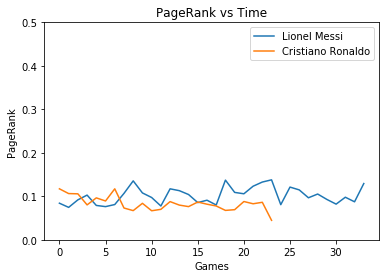

In [12]:
cont = 0
p = ['Lionel Messi','Cristiano Ronaldo']
for x in p:
    tmp = sorted(playergraphdata[x],key=lambda x:x[-1])
    tmp2 = map(lambda x : x[0]*95.0/(x[3]+1.0),tmp)
    plt.plot(range(len(tmp2)),tmp2,label=str(x))
    cont+=1
    if cont > 100 :
        break
plt.legend()
plt.ylim(0,0.5)
plt.title("PageRank vs Time")
plt.ylabel("PageRank")
plt.xlabel("Games")
plt.show()

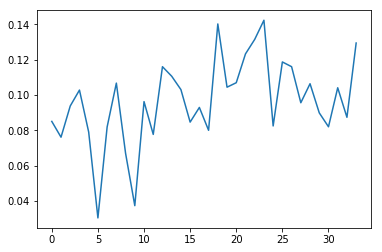

In [13]:
tmp = sorted(playergraphdata['Lionel Messi'],key = lambda x :x[-1])
tmp2 = map(lambda x : x[0],tmp)
plt.plot(range(len(tmp2)),tmp2)
plt.show()

In [14]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence

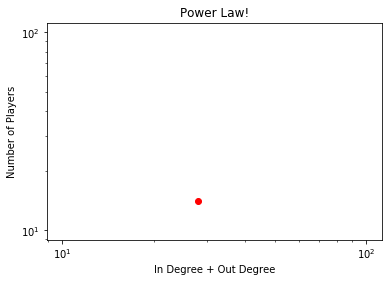

In [15]:
helpplot = {}
for x in degree_sequence :
    if x in helpplot:
        helpplot[x]+=1
    else :
        helpplot[x]=1
lists = sorted(helpplot.items())
x, y = zip(*lists)
plt.ylabel('Number of Players')
plt.xlabel('In Degree + Out Degree')
plt.title('Power Law!')
plt.loglog(x,y,'ro')
plt.show()

In [16]:
G.number_of_edges()

196

In [ ]:
page = nx.pagerank(G)
bet = nx.betweenness_centrality(G)
close = nx.closeness_centrality(G)
for x in playerdict:
    playerdict[x]['pagerank'] = page[x]
    playerdict[x]['closeness'] = close[x]
    playerdict[x]['betweeness'] = bet[x]

In [ ]:
player = G.nodes()
adj = nx.to_numpy_matrix(G)
ind = player.index('Lionel Messi')

In [ ]:
adj = nx.to_numpy_matrix(G)
model = NMF(n_components=4)
W = model.fit_transform(adj)

In [ ]:
count = 0
for x in player:
    playerdict[x]['features'] = list(W[count])
    count+=1

In [ ]:
playerdict['Lionel Messi']

In [ ]:
okay = KMeans(n_clusters=10)
okay = okay.fit_predict(W)

In [ ]:
clubbings = {}
for x in range(len(player)):
    if okay[x] in clubbings :
        name = player[x]
        clubbings[okay[x]].append(name)
    else :
        clubbings[okay[x]] = []

In [ ]:
for x in clubbings:
    print len(clubbings[x])

In [ ]:
# for x in clubbings :
#     print len(clubbings[x])

In [ ]:
print clubbings[0]

In [ ]:
for x in edgedict:
    G[x[0]][x[1]]['weight'] = G[x[0]][x[1]]['weight']/int(edgedict[x])

In [17]:
print playerfeat['Lionel Messi']

{'2009604': [0.5074353427763918, 0.504391701147194, 0.57047274537135517, 0.014239372529590812], '2009602': [0.43214837675881068, 1.2211317378544566, 1.0343668465415143, 0.70491301688091068], '2009516': [1.1153418588562225, 1.8576408287463151, 0.27713786942351931, 0.47900031417383293], '2015766': [0.0, 1.9323931803052974, 2.9535867612236624, 0.30366519755079191], '2009609': [1.1292552979400459, 0.59294008265158493, 0.14662678362437212, 2.1990177683975536], '2009596': [0.0087598512998662541, 2.6125880755476616, 0.7693163819017087, 1.4884247200467731], '2009492': [0.18886830665045587, 2.4996242016935928, 1.3122042913467047, 0.78788842595298225], '2009590': [1.0526894517474157, 2.0675647771500483, 0.34702284055126664, 0.0], '2011814': [2.4434144573175969, 0.48078318155398453, 1.0803913595077672, 1.2448918950609182], '2011865': [2.132534143488146, 0.706718958258023, 0.46725441001836349, 0.38679110635382585], '2019327': [0.27898465502992748, 0.0, 0.41351149743128124, 1.627585680462567], '201

In [104]:
t1,t2= [],[]
for x in sorted(playerfeat['Lionel Messi']):
    t1.append(playerfeat['Lionel Messi'][x][0])
    t2.append(playerfeat['Lionel Messi'][x][1])

In [103]:
print playerfeat['Lionel Messi']['2009604']

[0.50743534277639102, 0.50439170114719423, 0.57047274537135728, 0.014239372529590731]


In [106]:
plt.plot(range(len(t1)),t1)
plt.plot(range(len(t2)),t2)

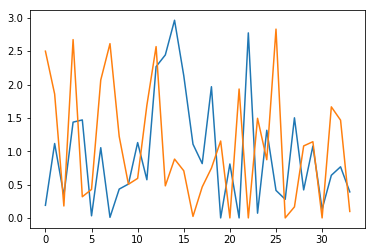

In [107]:
plt.show()

In [18]:
for x in sorted(teameigen['Barcelona']) :
    print teameigen['Barcelona'][x][0]

(64.948057972+0j)
(72.6910635075+0j)
(92.2999075051+0j)
(93.3210646667+0j)
(66.8274276497+0j)
(43.6292562612+0j)
(50.8332633249+0j)
(78.6356176311+0j)
(75.2423777969+0j)
(69.9710586343+0j)
(53.1979351458+0j)
(76.2694509135+0j)
(84.7732639266+0j)
(61.0821462569+0j)
(70.8704255022+0j)
(59.1085547806+0j)
(65.6050582546+0j)
(59.711785916+0j)
(66.6374639615+0j)
(65.3475740886+0j)
(58.6343859613+0j)
(40.9746200154+0j)
(63.2858382389+0j)
(61.5835099828+0j)
(59.4850052981+0j)
(60.7269270604+0j)
(67.9122844567+0j)
(67.1259816515+0j)
(32.4003712776+0j)
(46.6646570228+0j)
(57.6136743906+0j)
(96.287395839+0j)
(52.6251399206+0j)
(46.6012593681+0j)
(52.5143369438+0j)
(45.3023921009+0j)


In [120]:
for x in sorted(teameigen['Chelsea']) :
    print teameigen['Chelsea'][x][0]

(34.8357873384+0j)
(47.5786297525+0j)
(30.8924720185+0j)
(23.9964825407+0j)
(37.146912875+0j)
(39.6872353027+0j)
(44.2128673015+0j)
(49.8499414226+0j)
(37.5461574106+0j)
(56.6150132658+0j)
(34.5440485498+0j)
(64.1143844005+0j)
(27.5798239025+0j)
(37.4796586097+0j)
(34.0588389509+0j)
(34.2137129039+0j)
(17.7270418133+0j)
(34.9301116017+0j)
(52.911718296+0j)
(33.2334868112+0j)
(26.5711283565+0j)
(34.5582117685+0j)
(52.1250273343+0j)
(23.5776944719+0j)
(33.4346116484+0j)
(38.6577677709+0j)


In [93]:
teamstopeigen = {}
for x in teameigen :
    teamstopeigen[x] = []
    for a in sorted(teameigen[x]) :
        teameigen[x][a] = [int(np.real(teameigen[x][a][y])) for y in range(len(teameigen[x][a]))]
        teamstopeigen[x].append(teameigen[x][a])

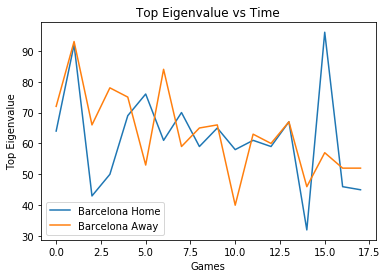

In [76]:
count = 0
t1 = ['Real Madrid Home','Real Madrid Away']
t2 = ['Barcelona Home','Barcelona Away']
for x in t2 :
    plt.plot(range(len(teamstopeigen[x])),teamstopeigen[x],label=x)
plt.legend()
plt.xlabel("Games")
plt.ylabel("Top Eigenvalue")
plt.title("Top Eigenvalue vs Time")
plt.show()

In [71]:
for x in playerpasses:
    playerpasses[x] = list(sorted(playerpasses[x],key =lambda x:x[-1]))
    for a in range(len(playerpasses[x])) :
        playerpasses[x][a] = list(playerpasses[x][a])
        playerpasses[x][a][0] = int(float(playerpasses[x][a][0])*95.0/(playerpasses[x][a][1]+1.0))
print playerpasses['Lionel Messi']

[[46, 95, '2009492'], [48, 96, '2009516'], [67, 96, '2009533'], [81, 94, '2009541'], [54, 94, '2009564'], [31, 37, '2009572'], [44, 95, '2009590'], [54, 94, '2009596'], [122, 46, '2009602'], [124, 32, '2009604'], [48, 93, '2009609'], [40, 94, '2011766'], [67, 93, '2011806'], [63, 92, '2011814'], [76, 93, '2011855'], [46, 93, '2011865'], [44, 96, '2011871'], [27, 94, '2011877'], [71, 96, '2015674'], [61, 90, '2015730'], [36, 95, '2015753'], [63, 94, '2015766'], [75, 93, '2015776'], [63, 97, '2015779'], [35, 96, '2015781'], [70, 92, '2019286'], [20, 95, '2019327'], [41, 93, '2019335'], [59, 95, '2019358'], [72, 91, '2019366'], [30, 94, '2019615'], [35, 100, '2019621'], [35, 94, '2019632'], [46, 94, '2019634']]


[46, 48, 67, 81, 54, 31, 44, 54, 122, 124, 48, 40, 67, 63, 76, 46, 44, 27, 71, 61, 36, 63, 75, 63, 35, 70, 20, 41, 59, 72, 30, 35, 35, 46]
[38, 37, 17, 16, 34, 21, 48, 31, 32, 36, 16, 25, 39, 27, 33, 31, 23, 19, 16, 28, 39, 27, 29, 12]


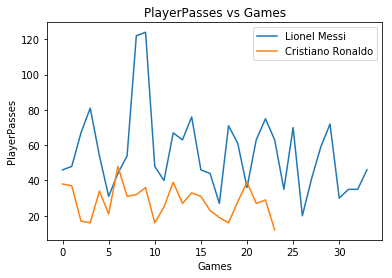

In [74]:
cont = 0
p = ['Lionel Messi','Cristiano Ronaldo']
for x in p:
    tmp2 = map(lambda x:x[0],playerpasses[x])
    print tmp2
    plt.plot(range(len(tmp2)),tmp2,label=str(x))
    cont+=1
    if cont > 100 :
        break
plt.legend()
plt.title("PlayerPasses vs Games")
plt.ylabel("PlayerPasses")
plt.xlabel("Games")
plt.show()

In [98]:
for r in range(len(teamstopeigen['Barcelona Home'])) :
    okay = teamstopeigen['Barcelona Home'][r]
    teamstopeigen['Barcelona Home'][r] = [x*1.0/okay[0] for x in okay]

In [96]:
print teamstopeigen['Barcelona Away']

[[1.0, 0.16666666666666666, 0.09722222222222222, 0.013888888888888888, 0.013888888888888888, 0.0, -0.027777777777777776, -0.06944444444444445, -0.06944444444444445, -0.1388888888888889, -0.18055555555555555, -0.25, -0.2777777777777778, -0.2777777777777778], [1.0, 0.21505376344086022, 0.053763440860215055, 0.010752688172043012, 0.0, -0.010752688172043012, -0.03225806451612903, -0.03225806451612903, -0.03225806451612903, -0.06451612903225806, -0.10752688172043011, -0.24731182795698925, -0.3118279569892473, -0.43010752688172044], [1.0, 0.16666666666666666, 0.15151515151515152, 0.0, 0.0, 0.0, -0.015151515151515152, -0.09090909090909091, -0.15151515151515152, -0.15151515151515152, -0.16666666666666666, -0.16666666666666666, -0.2727272727272727, -0.2727272727272727], [1.0, 0.14102564102564102, 0.14102564102564102, 0.0, 0.0, 0.0, -0.02564102564102564, -0.0641025641025641, -0.0641025641025641, -0.14102564102564102, -0.14102564102564102, -0.21794871794871795, -0.3076923076923077, -0.30769230769

In [99]:
from math import sqrt
Home = []
for r in range(len(teamstopeigen['Barcelona Home'])-1):
    subtractor = [a_i - b_i for a_i, b_i in zip(teamstopeigen['Barcelona Home'][r+1], teamstopeigen['Barcelona Home'][r])]
    subtractor = sqrt(sum([u*u for u in subtractor]))
    Home.append(subtractor)
print Home

[0.23788429013176426, 0.22437377845777715, 0.24627764235262825, 0.21730684349602, 0.2564429771123849, 0.212808445026824, 0.14175100613232275, 0.2527061004831388, 0.25681149228448363, 0.24532826544661426, 0.21177830591689037, 0.19302742236221446, 0.21266195866207988, 0.2723097796943314, 0.27282918445226656, 0.26785340774643474, 0.19349921783645782]


In [100]:
print Away,Home

[0.2063238930029302, 0.2719378098520647, 0.12279869838184597, 0.22147850565712485, 0.2247009888572322, 0.19776655428426043, 0.15149197863506972, 0.20493213915175604, 0.24805928387509527, 0.36708122069854193, 0.3574788983442251, 0.419336871069847, 0.21812019937573068, 0.22033848329194547, 0.2683960049084032, 0.27166305315921035, 0.22178004989751535] [0.23788429013176426, 0.22437377845777715, 0.24627764235262825, 0.21730684349602, 0.2564429771123849, 0.212808445026824, 0.14175100613232275, 0.2527061004831388, 0.25681149228448363, 0.24532826544661426, 0.21177830591689037, 0.19302742236221446, 0.21266195866207988, 0.2723097796943314, 0.27282918445226656, 0.26785340774643474, 0.19349921783645782]


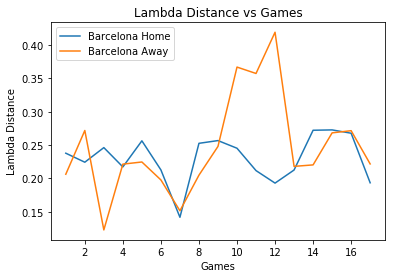

In [106]:
plt.plot(range(1,len(Home)+1),Home,label="Barcelona Home")
plt.plot(range(1,len(Away)+1),Away,label="Barcelona Away")
plt.legend()
plt.title("Lambda Distance vs Games")
plt.ylabel("Lambda Distance")
plt.xlabel("Games")
plt.show()

In [103]:
print Home

[0.23788429013176426, 0.22437377845777715, 0.24627764235262825, 0.21730684349602, 0.2564429771123849, 0.212808445026824, 0.14175100613232275, 0.2527061004831388, 0.25681149228448363, 0.24532826544661426, 0.21177830591689037, 0.19302742236221446, 0.21266195866207988, 0.2723097796943314, 0.27282918445226656, 0.26785340774643474, 0.19349921783645782]
